In [1]:
# Standard library imports
import os
import sys
import random
from pathlib import Path
from typing import Tuple, Any, Optional

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
import torch
import h5py
import openslide  # For whole slide image processing

# FastAI imports
from fastai.vision.all import *

# Custom libraries (update the path as per your project structure)
sys.path.append('/scratch/users/k21066795/prj_normal/RandStainNA')
from randstainna import RandStainNA
from pathlib import Path

from utils_Ordinalmodel import add_ageGroup, get_h5df

In [ ]:
# Setup paths
rootdir = Path("/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet")
cohort = "SGK_healthy"
WSIs = rootdir / "WSIs" / cohort
FEATURES = rootdir / "RootDir" / cohort
clinic_path = rootdir / f"DATA/clinicData/{cohort}.csv"

resFolder = "/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp"

In [ ]:
# Load and process clinical data
clinic_df = pd.read_csv(clinic_path)
clinic_df = add_ageGroup(clinic_df)

def add_ageGroup(df):
    df['age_group'] = 3
    df.loc[df['age']<55, 'age_group'] = 2
    df.loc[df['age']<45, 'age_group'] = 1
    df.loc[df['age']<35, 'age_group'] = 0
    return df

In [5]:
# Filter WSIs based on the existence of specific files
model_name = "gigapath"
wsi_ids = []
for wsi_id in clinic_df["wsi_id"]:
    # Look for files that match the pattern
    file = list(FEATURES.glob(f"{wsi_id}*/*{model_name}*reinhard.h5"))
    if file:  # Check if file list is not empty
        wsi_ids.append(wsi_id)

# Filter the clinical DataFrame
clinic_df = clinic_df[clinic_df["wsi_id"].isin(wsi_ids)]
print("Filtered DataFrame length:", len(clinic_df))
print("Unique age groups and counts:", np.unique(clinic_df["age_group"], return_counts=True))
clinic_df

Filtered DataFrame length: 915
Unique age groups and counts: (array([0, 1, 2, 3]), array([253, 210, 187, 265]))


,patient_id,wsi_id,age,BMI,Developed Breast Cancer,Breast Reduction,Brca1,Brca2,Cancer,Ever Had Cancer,age_group,cohort
2,K107432,K107432,33,29.5,No,No,No,No,NaN,No,0,SGK
4,K107878,K107878,59,28.2,No,No,No,No,NaN,No,3,SGK
7,K108029,K108029,41,22.6,No,No,No,No,NaN,No,1,SGK
9,K109153,K109153,34,21.0,No,No,No,No,NaN,No,0,SGK
10,K109156,K109156,32,21.3,No,No,No,No,NaN,No,0,SGK
...,...,...,...,...,...,...,...,...,...,...,...,...
1727,K109222,K109222,71,21.6,No,No,No,No,NaN,No,3,SGK
1728,K109223,K109223,51,17.7,No,No,No,No,NaN,No,2,SGK
1729,K109224,K109224,65,51.4,No,No,No,No,NaN,No,3,SGK
1735,K109232,K109232,46,23.4,No,No,No,No,NaN,No,2,SGK


In [7]:
# Filter patches by NBT-Classifier (>0.9)
valid_wsi = []
valid_patches = []

wsi_df = clinic_df

for wsi_id in wsi_df.wsi_id.values:
    
    fea_pt = f"{FEATURES}/{wsi_id}/{wsi_id}_bagFeature_{model_name}_reinhard.h5"
    with h5py.File(fea_pt, "r") as file:
        bag = np.array(file["embeddings"])
        bag = np.squeeze(bag)
        img_id = np.array(file["patch_id"])
    img_id = [i.decode("utf-8") for i in img_id]
    bag_df = pd.DataFrame(bag)
    bag_df.index = img_id

    csv_pt =  os.path.join(Path(fea_pt).parent, Path(fea_pt).stem.split('_bagFeature_')[0]+'_patch.csv')
    df = pd.read_csv(csv_pt)

    valid_id = list(df['patch_id'][df['TC_epi'] > 0.9])
    valid_id = list(set(valid_id) & set(bag_df.index))
    valid_patches.extend(valid_id)

    if valid_id:
        valid_wsi.extend([wsi_id] * len(valid_id))

print(len(np.unique(valid_wsi)))
print(len(valid_patches))

894
120854


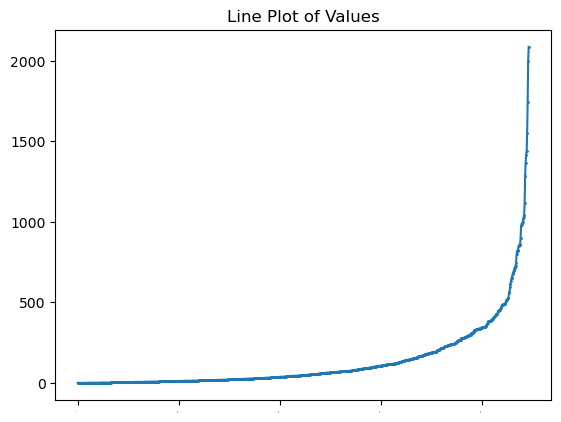

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 

In [28]:
a, b = np.unique(valid_wsi, return_counts=True)
sorted_zip = sorted(zip(b, a))

a = [i[1] for i in sorted_zip]
b = [i[0] for i in sorted_zip]

plt.plot(b , marker='o', markersize=1)
plt.title('Line Plot of Values')
plt.xticks(rotation=90, fontsize=1)
plt.show()

print(b)

In [40]:
wsi_ids = len(np.array(b)[np.array(b) < 5])
random.shuffle(wsi_ids)

wsis = []
imgs = []
rois = []
csv_files = []
ages = []
rois = []

for wsi_id in wsi_ids[:16]:
    wsi = f"{WSIs}/{wsi_id}.svs"
    roi = glob.glob(f"{FEATURES}/{wsi_id}/{wsi_id}_TC*.png")[0]
    wsi = openslide.OpenSlide(wsi)
    wsis.append(wsi)
    wsi_im = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert("RGB")
   
    imgs.append(np.array(wsi_im))
    rois.append(Image.open(roi))
    df_temp = pd.read_csv(f"{FEATURES}/{wsi_id}/{wsi_id}_patch_merge.csv")
    ages.append(np.unique(df_temp["age"])[0])
    csv_files.append(pd.read_csv(f"{FEATURES}/{wsi_id}/{wsi_id}_patch_merge.csv"))

for i in range(len(wsi_ids)):
    print(np.unique(csv_files[i]["wsi_id"])[0])
    print(np.unique(csv_files[i]["age"])[0])

K106821
76
K106860
24
K106875
49
K107018
38
K107032
39
K107073
43
K107185
49
K107302
56
K107676
41
K107819
58
K107937
21
K108306
49
K108570
24
K108649
29
K108725
66
K108930
58


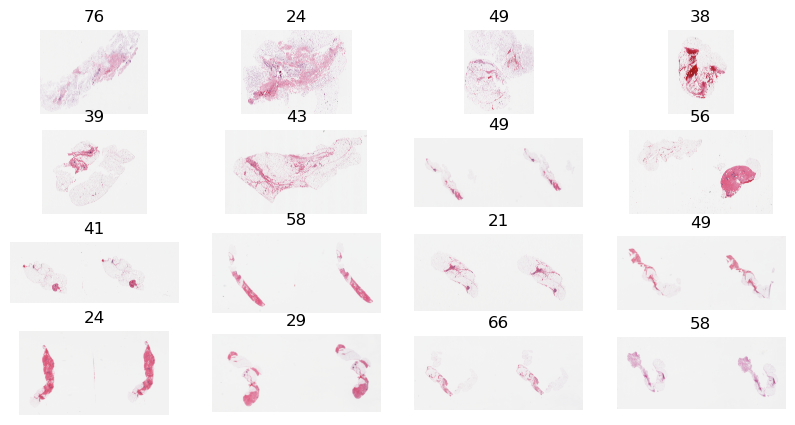

In [42]:
plot_multiple(img_list=imgs, caption_list=ages, grid_x=4, grid_y=4, figure_size=(10, 5), save_pt=None)

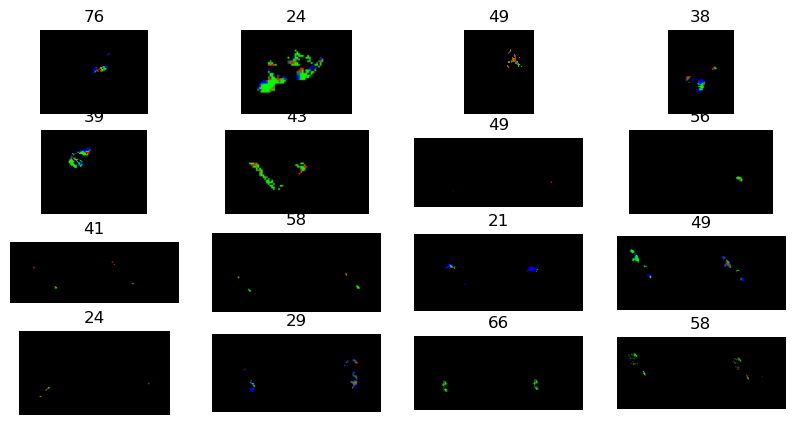

In [43]:
plot_multiple(img_list=rois, caption_list=ages, grid_x=4, grid_y=4, figure_size=(10, 5), save_pt=None)

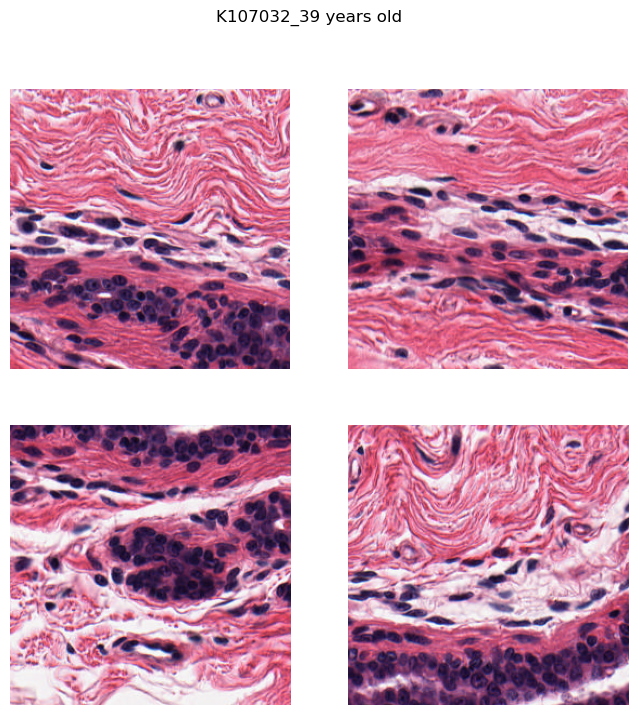

In [53]:
wsi_id = wsi_ids[4]
wsi = f"{WSIs}/{wsi_id}.svs"
wsi = openslide.OpenSlide(wsi)
df = pd.read_csv(f"{FEATURES}/{wsi_id}/{wsi_id}_patch_merge.csv")
patch_ids = list(df["patch_id"])
patch_ids = list(set(valid_patches) & set(patch_ids))


img_list = []
random.shuffle(patch_ids)
lens = min(len(patch_ids), 25)
if int(np.sqrt(lens)) <2:
    grid_x = 2
else:
    grid_x = int(np.sqrt(lens))
    
for i in range(lens):
    patch_id = patch_ids[i]
    x, y, patch_size = get_xy(patch_id)
    im = wsi.read_region((x, y), 0, (patch_size, patch_size)).convert("RGB")
    img_list.append(im)

prefix = f"{wsi_id}_{np.unique(df['age'])[0]}"
plot_multiple(img_list=img_list, caption_list=None, grid_x=grid_x, grid_y=grid_x, figure_size=(8, 8), 
              title=f"{prefix} years old", save_pt=None)

In [7]:
valid_ids = patient_df.loc[patient_df["number_of_patch"]>=5, "wsi_id"].values
print(len(valid_ids))
df = clinic_df.copy()
df = df.loc[df["wsi_id"].isin(valid_ids), :]
print(np.unique(df["age_group"], return_counts=True))
df.loc[:, "wsi_pt"] = [f"{WSIs}/{i}.svs" for i in df["wsi_id"].values]

777
(array([0, 1, 2, 3]), array([228, 188, 158, 203]))


In [8]:
patch_df = patch_df.loc[patch_df["wsi_id"].isin(valid_ids)].set_index("patch_id").iloc[:, 3:]
valid_patches = list(patch_df.index)
print(len(valid_patches))
# patch_df.to_csv("/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/DATA/pretrained_features/SGK_n777_Epithelium_gigapath_embeddings.csv")

111241


# Five-fold Cross-Validation

In [ ]:
# Extract patient IDs and true labels
patientID = df["patient_id"].values
truelabels = df["age_group"].values

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

# Generate train/test indexes for one fold
kf.get_n_splits(patientID, truelabels)

In [ ]:
foldcounter = 0
train_index, test_index = next(iter(kf.split(patientID, truelabels)))

In [9]:
# prepare the all df
all_df = df.copy()
feaBag_pts = [get_h5df(wsi_id, FEATURES, model_name, train=False) for wsi_id in all_df['wsi_id']]
all_df['h5df'] = [Path(i) for i in feaBag_pts]
all_df

,patient_id,wsi_id,age,BMI,Developed Breast Cancer,Breast Reduction,Brca1,Brca2,Cancer,Ever Had Cancer,age_group,cohort,wsi_pt,h5df
2,K107432,K107432,33,29.5,No,No,No,No,NaN,No,0,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/SGK_healthy/K107432.svs,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/SGK_healthy/K107432/K107432_bagFeature_gigapath_reinhard.h5
4,K107878,K107878,59,28.2,No,No,No,No,NaN,No,3,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/SGK_healthy/K107878.svs,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/SGK_healthy/K107878/K107878_bagFeature_gigapath_reinhard.h5
7,K108029,K108029,41,22.6,No,No,No,No,NaN,No,1,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/SGK_healthy/K108029.svs,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/SGK_healthy/K108029/K108029_bagFeature_gigapath_reinhard.h5
9,K109153,K109153,34,21.0,No,No,No,No,NaN,No,0,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/SGK_healthy/K109153.svs,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/SGK_healthy/K109153/K109153_bagFeature_gigapath_reinhard.h5
10,K109156,K109156,32,21.3,No,No,No,No,NaN,No,0,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/SGK_healthy/K109156.svs,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/SGK_healthy/K109156/K109156_bagFeature_gigapath_reinhard.h5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,K109222,K109222,71,21.6,No,No,No,No,NaN,No,3,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/SGK_healthy/K109222.svs,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/SGK_healthy/K109222/K109222_bagFeature_gigapath_reinhard.h5
1728,K109223,K109223,51,17.7,No,No,No,No,NaN,No,2,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/SGK_healthy/K109223.svs,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/SGK_healthy/K109223/K109223_bagFeature_gigapath_reinhard.h5
1729,K109224,K109224,65,51.4,No,No,No,No,NaN,No,3,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/SGK_healthy/K109224.svs,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/SGK_healthy/K109224/K109224_bagFeature_gigapath_reinhard.h5
1735,K109232,K109232,46,23.4,No,No,No,No,NaN,No,2,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/SGK_healthy/K109232.svs,/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/SGK_healthy/K109232/K109232_bagFeature_gigapath_reinhard.h5


In [10]:
# Prepare the test set
test_df = df.loc[df["patient_id"].isin(patientID[test_index]), :].copy()
feaBag_pts = [get_h5df(wsi_id, file_folder, model_name, train=False) for wsi_id in test_df['wsi_id']]
test_df['h5df'] = [Path(i) for i in feaBag_pts]

# Prepare the training set
train_df = df.loc[df["patient_id"].isin(patientID[train_index]), :].copy()

# Split the training set into training and validation
val_df = train_df.groupby('age_group', group_keys=False).apply(lambda x: x.sample(frac=0.2))
feaBag_pts = [get_h5df(wsi_id, file_folder, model_name, train=True) for wsi_id in val_df['wsi_id']]
val_df['h5df'] = [Path(i) for i in feaBag_pts]
val_df['is_valid'] = True

# Remove validation set samples from training set
train_df = train_df.drop(train_df[train_df['patient_id'].isin(val_df['patient_id'])].index).reset_index(drop=True)
feaBag_pts = [get_h5df(wsi_id, file_folder, model_name, train=True) for wsi_id in train_df['wsi_id']]
train_df['h5df'] = [Path(i) for i in feaBag_pts]
train_df['is_valid'] = False

# Combine the training and validation sets
train_df = pd.concat([train_df, val_df], axis=0).reset_index(drop=True)

# Output the class distributions
print("Training set class distribution:", np.unique(train_df.loc[train_df["is_valid"] == False, "age_group"], return_counts=True))
print("Validation set class distribution:", np.unique(train_df.loc[train_df["is_valid"] == True, "age_group"], return_counts=True))
print("Test set class distribution:", np.unique(test_df["age_group"], return_counts=True))

/tmp/ipykernel_699716/3690187431.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df = train_df.groupby('age_group', group_keys=False).apply(lambda x: x.sample(frac=0.2))


Training set class distribution: (array([0, 1, 2, 3]), array([146, 121, 101, 130]))
Validation set class distribution: (array([0, 1, 2, 3]), array([36, 30, 25, 32]))
Test set class distribution: (array([0, 1, 2, 3]), array([46, 37, 32, 41]))


## Training only on epithelium patches

In [13]:
bag_size = 150
cls = "epithelium"
batch_size = 16

dblock = DataBlock(blocks = (TransformBlock, CategoryBlock),
               get_x = ColReader('h5df'),
               get_y = ColReader('age_group'),
               splitter = ColSplitter('is_valid'),
               item_tfms = MILBagTransform(train_df.h5df, bag_size, valid_patches=valid_patches))

dls = dblock.dataloaders(train_df, bs = batch_size)
trainLoaders = dls.train
valLoaders = dls.valid

# for testing
(patch_ids, embeds), labels = next(iter(trainLoaders))
patch_ids = np.array(patch_ids)  # (150, 16)
patch_ids = np.transpose(patch_ids)  # 
print(patch_ids.shape, embeds.shape, labels.shape)

(16, 150) torch.Size([16, 150, 1536]) torch.Size([16])


In [ ]:
class MILBagTransform(Transform):
    def __init__(self, h5df_files, bag_size, valid_patches=None, clsname = None):
        self.h5df_files = h5df_files
        self.bag_size = bag_size
        self.valid_patches = valid_patches
        self.items = {f: self._draw(f) for f in h5df_files}
        self.clsname = clsname

    def encodes(self, f: Path):
        """Returns the bag of patches for a given file path."""
        return self.items.get(f, self._draw(f))

    def _sample_with_distinct_or_duplicate(self, population, k):
        """Sample k items from population, ensuring diversity in selection."""
        if len(population) >= k:
            return random.sample(population, k)  # Sample without replacement
        else:
            sampled_items = random.sample(population, len(population))  # Sample all unique items
            remaining_samples = random.choices(population, k=k - len(sampled_items))  # Fill with duplicates
            return sampled_items + remaining_samples

    def _draw(self, f: Path):
        """Draw a bag of patches from a given WSI."""
        if "augmentation" in str(f):  # Convert f to string for string operations
            chance = random.random() > 0.5
            if chance:
                f = str(f).replace("augmentation", "reinhard")  # Now replacing in the string
                f = Path(f)  # Convert it back to a Path object if needed

        with h5py.File(f, "r") as file:
            # Load embeddings and patch ids
            bag = np.array(file["embeddings"])
            img_id = np.array(file["patch_id"])

        # Decode patch ids if they are in bytes format
        img_id = [i.decode("utf-8") if isinstance(i, bytes) else i for i in img_id]
        
        bag_df = pd.DataFrame(bag)
        bag_df.index = img_id

        if self.valid_patches is not None:
            # patch_ids = np.intersect1d(self.valid_patches, list(bag_df.index))
            patch_ids = list(set(self.valid_patches) & set(bag_df.index))
        else:
            patch_ids = list(bag_df.index)

        patch_ids = list(np.unique(patch_ids))
        sampled_items = self._sample_with_distinct_or_duplicate(patch_ids, self.bag_size)

        bag_df = bag_df.loc[sampled_items, :]
        bag_df = np.squeeze(np.array(bag_df))
        bag_df = torch.from_numpy(bag_df)

        return sampled_items, bag_df

In [33]:
attention = "MultiHeadAttention"
n_heads = 8
n_feats = get_dim_input(model_name)
n_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = BreastAgeNet(n_feats, attention, n_classes, n_heads=8, n_latent=512, embed_attn=False).to(device)

cuda


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_in, n_heads, n_latent: Optional[int] = None, dropout: float = 0.1) -> None:
        super().__init__()
        self.n_heads = n_heads
        n_latent = n_latent or n_in
        self.d_k = n_latent // n_heads
        self.q_proj = nn.Linear(n_in, n_latent)
        self.k_proj = nn.Linear(n_in, n_latent)
        self.fc = nn.Linear(n_heads, 1)  
        self.dropout = nn.Dropout(dropout)
        self.split_heads = lambda x: x.view(x.shape[0], x.shape[1], self.n_heads, self.d_k).transpose(1, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        Q = torch.tanh(self.q_proj(x))  # Project Q
        K = torch.sigmoid(self.k_proj(x))  # Project K
        
        Q = self.split_heads(Q)  # [batch_size, n_heads, bag_size, d_k]
        K = self.split_heads(K)  # [batch_size, n_heads, bag_size, d_k]

        # Calculate attention scores
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)  # Scaled dot-product
        attention_weights = F.softmax(attention_scores, dim=-1)  # Softmax to get weights
        attention_weights = self.dropout(attention_weights)  # Apply dropout for regularization
        
        # Aggregate attention weights
        attention_output = attention_weights.mean(dim=-2)  # Aggregate across bag_size
       
        attention_output = attention_output.transpose(1, 2).contiguous().view(x.shape[0], x.shape[1], -1)  # Flatten heads
      
        output = self.fc(attention_output)  # Final linear layer for output

        return output
    
    
    
######### attention modules
def Attention(n_in, n_latent: Optional[int] = None) -> nn.Module:
    
    n_latent = n_latent or (n_in +1) // 2
    
    return nn.Sequential(
        nn.Linear(n_in, n_latent),
        nn.Tanh(),
        nn.Linear(n_latent, 1)
    )



class GatedAttention(nn.Module):

    def __init__(self, n_in, n_latent: Optional[int] = None) -> None:
        super().__init__()
        n_latent = n_latent or (n_in + 1) // 2

        self.fc1 = nn.Linear(n_in, n_latent)
        self.gate = nn.Linear(n_in, n_latent)
        self.fc2 = nn.Linear(n_latent, 1)

    def forward(self, h: torch.Tensor) -> torch.Tensor:
        return self.fc2(torch.tanh(self.fc1(h)) * torch.sigmoid(self.gate(h)))

In [ ]:
class BreastAgeNet(nn.Module):
    def __init__(self, n_feats, attention, n_classes, n_heads=8, n_latent=512, embed_attn=False, temperature=None):
        super(BreastAgeNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_feats, n_latent),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Choose the attention mechanism for each class
        if attention == 'MultiHeadAttention':
            self.attentions = nn.ModuleList([MultiHeadAttention(n_latent, n_heads) for _ in range(n_classes)])
        elif attention == 'Attention':
            self.attentions = nn.ModuleList([Attention(n_latent) for _ in range(n_classes)])
        elif attention == 'GatedAttention':
            self.attentions = nn.ModuleList([GatedAttention(n_latent) for _ in range(n_classes)])
        
        
        # Bag classifiers for each class
        self.classifiers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_latent, n_latent // 2),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(n_latent // 2, 1)
            ) for _ in range(n_classes)
        ])
        
        self.n_classes = n_classes
        self.embed_attn = embed_attn
        self.temperature = temperature

    
    def forward(self, bags):
        bags = bags.to(next(self.parameters()).device)  # Ensure bags are on the correct device
        embeddings = self.encoder(bags)  # [batch_size, bag_size, n_latent]

        logits = []
        attns = []
        for i in range(self.n_classes):
            # Get attention scores for the current class
            attention_scores = self.attentions[i](embeddings)  # [batch_size, bag_size, 1]
            
            if self.temperature is not None:  # Adjust based on experimentation
                attention_scores = attention_scores / temperature

            attns.append(attention_scores)
            A = F.softmax(attention_scores, dim=1)            
            # Apply weighted sum for each instance in the bag
            M = torch.bmm(A.transpose(1, 2), embeddings)  # [batch_size, 1, n_latent]
            M = M.squeeze(1)  # Ensure we only remove the bag_size dimension
            
            # Pass through classifier to get logits for this class
            logit = self.classifiers[i](M)  # [batch_size, 1]
            logits.append(logit)
        
        # Stack logits along a new dimension for consistent output shape
        logits = torch.cat(logits, dim=1)  # [batch_size, n_classes]

        # Concatenate attention scores across classes along dim=2
        attns = torch.cat(attns, dim=2)  # [batch_size, bag_size, n_classes]

        # Return embeddings and attention weights if requested
        if self.embed_attn:
            return logits, embeddings, attns  # logits: [batch_size, n_classes], embeddings: [batch_size, bag_size, n_latent], attns: [batch_size, bag_size, n_classes]
        else:
            return logits  # [batch_size, n_classes]

In [34]:
lr = 0.00001 # optimiser's lr
weight_decay = 0.00005 # optimiser's regularity

patience = 10
minEpochTrain = 0


optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
early_stopping = EarlyStopping(patience=patience, stop_epoch=minEpochTrain, verbose=True)


value_counts = train_df.loc[(train_df["is_valid"] == False) & (train_df["age_group"] != 0), "age_group"].value_counts()
# Reverse weights: 1 / frequency (this will give higher weights to less frequent classes)
reversed_weights = 1.0 / (value_counts / value_counts.sum())  # Inverse of frequency-based weights
# Normalize to prevent extreme values (optional but often helps with stability)
reversed_weights = reversed_weights / reversed_weights.sum()  # Normalize the weights to sum to 1
# Convert the pandas Series to a tensor before using .to(device)
weights = torch.tensor(reversed_weights.values, dtype=torch.float32).to(device)  # Convert to tensor and move to device
print(weights)

# Instantiate the loss function with weighted loss
criterion = OrdinalCrossEntropyLoss(n_classes=n_classes, weights=weights)
criterion.to(device)  # Move to GPU if applicable

tensor([0.2975, 0.3196, 0.3829], device='cuda:0')


OrdinalCrossEntropyLoss(
  (bce): BCEWithLogitsLoss()
)

In [35]:
class OrdinalCrossEntropyLoss(nn.Module):
    def __init__(self, n_classes, weights=None):
        super(OrdinalCrossEntropyLoss, self).__init__()
        self.num_classes = n_classes
        self.bce = nn.BCEWithLogitsLoss(reduction='none')  # Use 'none' to handle weights manually
        self.weights = weights

    def forward(self, logits, labels):
        # Expand labels to create binary labels for each class threshold
        labels_expanded = labels.unsqueeze(1).repeat(1, self.num_classes)  # [batch_size, n_classes]
        
        # Create binary labels: [0,0,0], [1,0,0], [1,1,0], [1,1,1], etc.
        binary_labels = (labels_expanded > torch.arange(self.num_classes).to(labels.device)).float()
        
        # Compute the BCE loss for each class (ignoring the reduction)
        loss = self.bce(logits, binary_labels)

        # If weights are provided, apply them (per sample, per class)
        if self.weights is not None:
            loss = loss * self.weights
            return loss.mean()   # Apply weights based on true class
        else:
            # Return the average loss
            return loss.mean()  # Averaging over the batch



class EarlyStopping:
    def __init__(self, patience = 20, stop_epoch = 50, verbose=False):

        self.patience = patience
        self.stop_epoch = stop_epoch
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, epoch, val_loss, model, ckpt_name = 'checkpoint.pt'):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, ckpt_name)
        elif score < self.best_score:
            self.counter += 1
            print(f'\nEarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience and epoch > self.stop_epoch:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, ckpt_name)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, ckpt_name):
        if self.verbose:
            print(f'\nValidation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), ckpt_name)
        self.val_loss_min = val_loss    

In [ ]:
max_epochs =200
ckpt_name = f'{resFolder}/{cls}_{model_name}_{bag_size}_{attention}_{n_heads}_fold{foldcounter}_MILbestModel.pt'

since = time.time()

train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

for epoch in range(max_epochs):
    print(f"Epoch {epoch}/{max_epochs-1}\n")
    print('Training phase\n')
    
    # Training phase
    phase = 'train'
    model.train()
    running_loss = 0.0
    running_mae = 0.0

    for (_, inputs), labels in tqdm(trainLoaders):  # inputs = (embeddings, patch lens)
        optimizer.zero_grad()

        # Forward pass
        with torch.set_grad_enabled(True):
            logits = model(inputs)
            loss = criterion(logits, labels)  # BCEWithLogitsLoss expects logits as inputs

            # Backpropagation and optimization
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # Accumulate loss and MAE
            running_loss += loss.item()
            probs = torch.sigmoid(logits)  # Shape: [batch_size, n_classes]
            binary_predictions = (probs > 0.5).int()  # Shape: [batch_size, n_classes]
            predicted_ranks = binary_predictions.sum(dim=1)  # Shape: [batch_size]
            running_mae += torch.abs(labels - predicted_ranks).float().mean().item()

    # Calculate average loss and MAE for the epoch
    epoch_loss = running_loss / len(trainLoaders)
    epoch_acc = running_mae / len(trainLoaders)
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    print(f'\nTraining Loss: {np.round(epoch_loss, 4)}  MAE: {np.round(epoch_acc, 4)}')

    # Validation phase
    if valLoaders:
        print('Validation phase\n')
        phase = 'val'
        model.eval()
        
        running_loss = 0.0
        running_mae = 0.0
        with torch.no_grad():
            for (_, inputs), labels in tqdm(valLoaders):
                logits = model(inputs)
                loss = criterion(logits, labels)
                
                # Accumulate loss and MAE
                running_loss += loss.item()
                probs = torch.sigmoid(logits)  # Shape: [batch_size, n_classes]
                binary_predictions = (probs > 0.5).int()  # Shape: [batch_size, n_classes]
                predicted_ranks = binary_predictions.sum(dim=1)  # Shape: [batch_size]
                running_mae += torch.abs(labels - predicted_ranks).float().mean().item()

        # Calculate average loss and MAE for validation
        val_loss = running_loss / len(valLoaders)
        val_acc = running_mae / len(valLoaders)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'Validation Loss: {np.round(val_loss, 4)}   MAE: {np.round(val_acc, 4)}')

        # Early stopping and checkpointing
        early_stopping(epoch, val_loss, model, ckpt_name=ckpt_name)
        if early_stopping.early_stop:
            print('-' * 30)
            print(f'Early stopping: validation loss did not improve for {patience} epochs!')
            print('-' * 30)
            break

    print('-' * 30)

time_elapsed = time.time() - since
print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Epoch 0/199

Training phase



100%|██████████| 31/31 [00:29<00:00,  1.07it/s]



Training Loss: 0.2236  MAE: 1.0665
Validation phase



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Validation Loss: 0.2185   MAE: 0.9737

Validation loss decreased (inf --> 0.218534).  Saving model ...
------------------------------
Epoch 1/199

Training phase



100%|██████████| 31/31 [00:22<00:00,  1.38it/s]



Training Loss: 0.2135  MAE: 0.9758
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Validation Loss: 0.2117   MAE: 1.0121

Validation loss decreased (0.218534 --> 0.211663).  Saving model ...
------------------------------
Epoch 2/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.42it/s]



Training Loss: 0.2067  MAE: 0.9375
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Validation Loss: 0.2077   MAE: 1.0121

Validation loss decreased (0.211663 --> 0.207735).  Saving model ...
------------------------------
Epoch 3/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.42it/s]



Training Loss: 0.2029  MAE: 0.9677
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Validation Loss: 0.2053   MAE: 1.0199

Validation loss decreased (0.207735 --> 0.205320).  Saving model ...
------------------------------
Epoch 4/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.42it/s]



Training Loss: 0.2004  MAE: 0.9294
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Validation Loss: 0.2036   MAE: 1.0007

Validation loss decreased (0.205320 --> 0.203582).  Saving model ...
------------------------------
Epoch 5/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.48it/s]



Training Loss: 0.1979  MAE: 0.9073
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Validation Loss: 0.2018   MAE: 0.978

Validation loss decreased (0.203582 --> 0.201789).  Saving model ...
------------------------------
Epoch 6/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.43it/s]



Training Loss: 0.1954  MAE: 0.9153
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Validation Loss: 0.2   MAE: 0.9545

Validation loss decreased (0.201789 --> 0.199963).  Saving model ...
------------------------------
Epoch 7/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1922  MAE: 0.8629
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Validation Loss: 0.1982   MAE: 0.951

Validation loss decreased (0.199963 --> 0.198196).  Saving model ...
------------------------------
Epoch 8/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1895  MAE: 0.877
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1964   MAE: 0.924

Validation loss decreased (0.198196 --> 0.196382).  Saving model ...
------------------------------
Epoch 9/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.44it/s]



Training Loss: 0.1875  MAE: 0.8548
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Validation Loss: 0.1948   MAE: 0.9048

Validation loss decreased (0.196382 --> 0.194797).  Saving model ...
------------------------------
Epoch 10/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1852  MAE: 0.8306
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Validation Loss: 0.1932   MAE: 0.8814

Validation loss decreased (0.194797 --> 0.193179).  Saving model ...
------------------------------
Epoch 11/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1823  MAE: 0.8246
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1915   MAE: 0.8857

Validation loss decreased (0.193179 --> 0.191465).  Saving model ...
------------------------------
Epoch 12/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.179  MAE: 0.8165
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Validation Loss: 0.1899   MAE: 0.8587

Validation loss decreased (0.191465 --> 0.189894).  Saving model ...
------------------------------
Epoch 13/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.44it/s]



Training Loss: 0.1782  MAE: 0.8105
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Validation Loss: 0.1887   MAE: 0.8473

Validation loss decreased (0.189894 --> 0.188674).  Saving model ...
------------------------------
Epoch 14/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1735  MAE: 0.7762
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Validation Loss: 0.1872   MAE: 0.8629

Validation loss decreased (0.188674 --> 0.187169).  Saving model ...
------------------------------
Epoch 15/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1726  MAE: 0.7944
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1861   MAE: 0.8551

Validation loss decreased (0.187169 --> 0.186141).  Saving model ...
------------------------------
Epoch 16/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1697  MAE: 0.7641
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1855   MAE: 0.8551

Validation loss decreased (0.186141 --> 0.185543).  Saving model ...
------------------------------
Epoch 17/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1688  MAE: 0.7702
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Validation Loss: 0.184   MAE: 0.8473

Validation loss decreased (0.185543 --> 0.184017).  Saving model ...
------------------------------
Epoch 18/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1658  MAE: 0.756
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Validation Loss: 0.1832   MAE: 0.8359

Validation loss decreased (0.184017 --> 0.183229).  Saving model ...
------------------------------
Epoch 19/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.164  MAE: 0.7581
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Validation Loss: 0.1824   MAE: 0.8089

Validation loss decreased (0.183229 --> 0.182379).  Saving model ...
------------------------------
Epoch 20/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.50it/s]



Training Loss: 0.1614  MAE: 0.7137
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1827   MAE: 0.8281

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 21/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.47it/s]



Training Loss: 0.1605  MAE: 0.7177
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Validation Loss: 0.1812   MAE: 0.8402

Validation loss decreased (0.182379 --> 0.181188).  Saving model ...
------------------------------
Epoch 22/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.49it/s]



Training Loss: 0.1587  MAE: 0.7077
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1809   MAE: 0.8324

Validation loss decreased (0.181188 --> 0.180905).  Saving model ...
------------------------------
Epoch 23/199

Training phase



100%|██████████| 31/31 [00:25<00:00,  1.21it/s]



Training Loss: 0.1581  MAE: 0.7319
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1804   MAE: 0.8402

Validation loss decreased (0.180905 --> 0.180389).  Saving model ...
------------------------------
Epoch 24/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.44it/s]



Training Loss: 0.1551  MAE: 0.7016
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1792   MAE: 0.8324

Validation loss decreased (0.180389 --> 0.179205).  Saving model ...
------------------------------
Epoch 25/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1548  MAE: 0.6714
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Validation Loss: 0.1796   MAE: 0.8246

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 26/199

Training phase



100%|██████████| 31/31 [00:23<00:00,  1.34it/s]



Training Loss: 0.1531  MAE: 0.6673
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1785   MAE: 0.8402

Validation loss decreased (0.179205 --> 0.178492).  Saving model ...
------------------------------
Epoch 27/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1532  MAE: 0.6996
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1774   MAE: 0.8253

Validation loss decreased (0.178492 --> 0.177360).  Saving model ...
------------------------------
Epoch 28/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1502  MAE: 0.6472
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1773   MAE: 0.8253

Validation loss decreased (0.177360 --> 0.177294).  Saving model ...
------------------------------
Epoch 29/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1518  MAE: 0.6754
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1776   MAE: 0.8132

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 30/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1491  MAE: 0.6411
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1761   MAE: 0.8331

Validation loss decreased (0.177294 --> 0.176064).  Saving model ...
------------------------------
Epoch 31/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.47it/s]



Training Loss: 0.1497  MAE: 0.6532
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Validation Loss: 0.1777   MAE: 0.8516

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 32/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.48it/s]



Training Loss: 0.1472  MAE: 0.6351
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.175   MAE: 0.8487

Validation loss decreased (0.176064 --> 0.175040).  Saving model ...
------------------------------
Epoch 33/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1474  MAE: 0.629
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1753   MAE: 0.8253

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 34/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1473  MAE: 0.6492
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1761   MAE: 0.8594

EarlyStopping counter: 2 out of 10
------------------------------
Epoch 35/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1451  MAE: 0.6331
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.33it/s]


Validation Loss: 0.1765   MAE: 0.8359

EarlyStopping counter: 3 out of 10
------------------------------
Epoch 36/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1451  MAE: 0.6169
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Validation Loss: 0.1724   MAE: 0.8409

Validation loss decreased (0.175040 --> 0.172442).  Saving model ...
------------------------------
Epoch 37/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.48it/s]



Training Loss: 0.1434  MAE: 0.625
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1736   MAE: 0.8288

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 38/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1415  MAE: 0.6129
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Validation Loss: 0.1719   MAE: 0.8288

Validation loss decreased (0.172442 --> 0.171905).  Saving model ...
------------------------------
Epoch 39/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.141  MAE: 0.6048
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1729   MAE: 0.821

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 40/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1406  MAE: 0.6089
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1716   MAE: 0.821

Validation loss decreased (0.171905 --> 0.171648).  Saving model ...
------------------------------
Epoch 41/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1393  MAE: 0.5948
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Validation Loss: 0.1737   MAE: 0.8011

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 42/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1392  MAE: 0.5847
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Validation Loss: 0.1719   MAE: 0.7898

EarlyStopping counter: 2 out of 10
------------------------------
Epoch 43/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1384  MAE: 0.6089
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1703   MAE: 0.8054

Validation loss decreased (0.171648 --> 0.170282).  Saving model ...
------------------------------
Epoch 44/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1365  MAE: 0.5927
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Validation Loss: 0.1712   MAE: 0.782

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 45/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.47it/s]



Training Loss: 0.136  MAE: 0.5887
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Validation Loss: 0.1696   MAE: 0.8054

Validation loss decreased (0.170282 --> 0.169612).  Saving model ...
------------------------------
Epoch 46/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1359  MAE: 0.5786
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1707   MAE: 0.7898

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 47/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.42it/s]



Training Loss: 0.1352  MAE: 0.5544
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Validation Loss: 0.1699   MAE: 0.8054

EarlyStopping counter: 2 out of 10
------------------------------
Epoch 48/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1339  MAE: 0.5685
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Validation Loss: 0.1705   MAE: 0.7741

EarlyStopping counter: 3 out of 10
------------------------------
Epoch 49/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1336  MAE: 0.5585
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1699   MAE: 0.7741

EarlyStopping counter: 4 out of 10
------------------------------
Epoch 50/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.47it/s]



Training Loss: 0.1325  MAE: 0.5464
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Validation Loss: 0.1688   MAE: 0.782

Validation loss decreased (0.169612 --> 0.168846).  Saving model ...
------------------------------
Epoch 51/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1311  MAE: 0.5403
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1689   MAE: 0.7898

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 52/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1316  MAE: 0.5484
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Validation Loss: 0.1666   MAE: 0.7898

Validation loss decreased (0.168846 --> 0.166568).  Saving model ...
------------------------------
Epoch 53/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.48it/s]



Training Loss: 0.1304  MAE: 0.5544
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1674   MAE: 0.7898

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 54/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1308  MAE: 0.5423
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1676   MAE: 0.782

EarlyStopping counter: 2 out of 10
------------------------------
Epoch 55/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1286  MAE: 0.5343
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Validation Loss: 0.167   MAE: 0.782

EarlyStopping counter: 3 out of 10
------------------------------
Epoch 56/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.44it/s]



Training Loss: 0.1298  MAE: 0.5645
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1664   MAE: 0.7976

Validation loss decreased (0.166568 --> 0.166416).  Saving model ...
------------------------------
Epoch 57/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.47it/s]



Training Loss: 0.1281  MAE: 0.5423
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1667   MAE: 0.7898

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 58/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1285  MAE: 0.5464
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1663   MAE: 0.7976

Validation loss decreased (0.166416 --> 0.166263).  Saving model ...
------------------------------
Epoch 59/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1272  MAE: 0.5444
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1659   MAE: 0.782

Validation loss decreased (0.166263 --> 0.165856).  Saving model ...
------------------------------
Epoch 60/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1267  MAE: 0.5383
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Validation Loss: 0.1655   MAE: 0.7976

Validation loss decreased (0.165856 --> 0.165454).  Saving model ...
------------------------------
Epoch 61/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.44it/s]



Training Loss: 0.1267  MAE: 0.5403
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Validation Loss: 0.1654   MAE: 0.7898

Validation loss decreased (0.165454 --> 0.165371).  Saving model ...
------------------------------
Epoch 62/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1262  MAE: 0.5363
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Validation Loss: 0.1647   MAE: 0.7741

Validation loss decreased (0.165371 --> 0.164709).  Saving model ...
------------------------------
Epoch 63/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.124  MAE: 0.5403
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1645   MAE: 0.7663

Validation loss decreased (0.164709 --> 0.164510).  Saving model ...
------------------------------
Epoch 64/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.47it/s]



Training Loss: 0.1227  MAE: 0.4919
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Validation Loss: 0.1658   MAE: 0.7741

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 65/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1245  MAE: 0.5101
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Validation Loss: 0.1628   MAE: 0.782

Validation loss decreased (0.164510 --> 0.162779).  Saving model ...
------------------------------
Epoch 66/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.123  MAE: 0.506
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Validation Loss: 0.1645   MAE: 0.7663

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 67/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1232  MAE: 0.5282
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1663   MAE: 0.7507

EarlyStopping counter: 2 out of 10
------------------------------
Epoch 68/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1234  MAE: 0.5
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1669   MAE: 0.7351

EarlyStopping counter: 3 out of 10
------------------------------
Epoch 69/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.47it/s]



Training Loss: 0.1207  MAE: 0.494
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Validation Loss: 0.1639   MAE: 0.7507

EarlyStopping counter: 4 out of 10
------------------------------
Epoch 70/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.43it/s]



Training Loss: 0.1222  MAE: 0.5081
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1627   MAE: 0.755

Validation loss decreased (0.162779 --> 0.162705).  Saving model ...
------------------------------
Epoch 71/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1193  MAE: 0.498
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Validation Loss: 0.1631   MAE: 0.7472

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 72/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1204  MAE: 0.5161
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Validation Loss: 0.1655   MAE: 0.7273

EarlyStopping counter: 2 out of 10
------------------------------
Epoch 73/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1187  MAE: 0.4919
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Validation Loss: 0.1623   MAE: 0.7393

Validation loss decreased (0.162705 --> 0.162304).  Saving model ...
------------------------------
Epoch 74/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.47it/s]



Training Loss: 0.1187  MAE: 0.4919
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1623   MAE: 0.7472

Validation loss decreased (0.162304 --> 0.162289).  Saving model ...
------------------------------
Epoch 75/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.47it/s]



Training Loss: 0.1186  MAE: 0.4879
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Validation Loss: 0.1634   MAE: 0.7315

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 76/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1184  MAE: 0.4899
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Validation Loss: 0.1616   MAE: 0.7237

Validation loss decreased (0.162289 --> 0.161565).  Saving model ...
------------------------------
Epoch 77/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1151  MAE: 0.4919
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Validation Loss: 0.1621   MAE: 0.7237

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 78/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.47it/s]



Training Loss: 0.1188  MAE: 0.5081
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Validation Loss: 0.1633   MAE: 0.7237

EarlyStopping counter: 2 out of 10
------------------------------
Epoch 79/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1169  MAE: 0.4899
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1619   MAE: 0.7315

EarlyStopping counter: 3 out of 10
------------------------------
Epoch 80/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.117  MAE: 0.4919
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1642   MAE: 0.7159

EarlyStopping counter: 4 out of 10
------------------------------
Epoch 81/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.49it/s]



Training Loss: 0.1172  MAE: 0.4919
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1629   MAE: 0.7003

EarlyStopping counter: 5 out of 10
------------------------------
Epoch 82/199

Training phase



100%|██████████| 31/31 [00:20<00:00,  1.48it/s]



Training Loss: 0.1148  MAE: 0.4798
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.1617   MAE: 0.7003

EarlyStopping counter: 6 out of 10
------------------------------
Epoch 83/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1154  MAE: 0.4839
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1613   MAE: 0.7081

Validation loss decreased (0.161565 --> 0.161313).  Saving model ...
------------------------------
Epoch 84/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1144  MAE: 0.4778
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation Loss: 0.1624   MAE: 0.7159

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 85/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1149  MAE: 0.4617
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation Loss: 0.163   MAE: 0.7081

EarlyStopping counter: 2 out of 10
------------------------------
Epoch 86/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1142  MAE: 0.496
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Validation Loss: 0.1613   MAE: 0.7159

Validation loss decreased (0.161313 --> 0.161250).  Saving model ...
------------------------------
Epoch 87/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1132  MAE: 0.4738
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Validation Loss: 0.162   MAE: 0.7237

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 88/199

Training phase



100%|██████████| 31/31 [00:23<00:00,  1.30it/s]



Training Loss: 0.112  MAE: 0.4536
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Validation Loss: 0.1617   MAE: 0.7081

EarlyStopping counter: 2 out of 10
------------------------------
Epoch 89/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1133  MAE: 0.4698
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Validation Loss: 0.1617   MAE: 0.7159

EarlyStopping counter: 3 out of 10
------------------------------
Epoch 90/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.45it/s]



Training Loss: 0.1121  MAE: 0.4435
Validation phase



100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Validation Loss: 0.1692   MAE: 0.7507

EarlyStopping counter: 4 out of 10
------------------------------
Epoch 91/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



Training Loss: 0.1108  MAE: 0.4718
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Validation Loss: 0.1606   MAE: 0.7159

Validation loss decreased (0.161250 --> 0.160613).  Saving model ...
------------------------------
Epoch 92/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.44it/s]



Training Loss: 0.1125  MAE: 0.4657
Validation phase



100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Validation Loss: 0.1642   MAE: 0.7159

EarlyStopping counter: 1 out of 10
------------------------------
Epoch 93/199

Training phase



100%|██████████| 31/31 [00:21<00:00,  1.43it/s]



Training Loss: 0.1124  MAE: 0.4577
Validation phase



 12%|█▎        | 1/8 [00:03<00:23,  3.31s/it]

In [ ]:
def plot_training(train_loss_history, val_loss_history, train_acc_history, val_acc_history, save_pt=None):
    
    epochs = range(1, len(train_loss_history) + 1) 
    
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot Loss
    ax1.plot(epochs, train_loss_history, label='Training Loss', color='blue')
    ax1.plot(epochs, val_loss_history, label='Validation Loss', color='orange')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()
    
    # Plot Accuracy
    ax2.plot(epochs, train_acc_history, label='Training Accuracy', color='green')
    ax2.plot(epochs, val_acc_history, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()
    
    # Show plots
    plt.tight_layout()
    if save_pt is not None:
        plt.savefig(save_pt)
    plt.show()


plot_training(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

In [ ]:
def test_model(model, dataloaders):
    phase = 'test'
    model.eval()

    predicted_ranks = []
    for item in tqdm(dataloaders):
        _, inputs = item[0]
        with torch.set_grad_enabled(phase=='train'):
            logits = model(inputs)
            probs = torch.sigmoid(logits)  # Shape: [batch_size, n_classes]
            binary_predictions = (probs > 0.5).int()  # Shape: [batch_size, n_classes]
            ranks = binary_predictions.sum(dim=1)  # Shape: [batch_size]
            predicted_ranks = predicted_ranks + ranks.tolist()
    
    return predicted_ranks

testLoader = dls.test_dl(test_df)
predicted_ranks = test_model(model, testLoader)
MAE = np.abs(test_df["age_group"].values - predicted_ranks).mean()
MAE

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline
# True labels and predictions

y_true = test_df["age_group"].values
y_pred = predicted_ranks

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            annot_kws={"size": 12})  # Increase font size if needed

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()